In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:

#  O my body, make of me always a man who questions!

import spacy
import re
import pandas as pd
import numpy as np
import requests
from spacy.matcher import Matcher 

import networkx as nx

import matplotlib.pyplot as plt

from common import *

nlp = spacy.load('en_core_web_sm')

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


In [3]:
book = read_file('data/Strang-Linear Algebra.txt')

In [4]:
def sentence_fits(s):
    """Check if sentence contains only one subject and one object"""
    deps = ''.join([token.dep_ for token in nlp(s)])
    return deps.count('obj') == 1 & deps.count('subj') == 1
    

In [5]:
chapter = list(get_one_chapter_strang(4, book, subsections=False))[0]

sentences = [i for i in chapter if sentence_fits(i)]
sentences

['They test for invertibility.',
 'The simplest box is a little cube dV = dxdydz, as in RRR f (x;y; z)dV.',
 'Just as a small interval dx is stretched to (dx=du)duwhen u replaces x in a single integralso the volume element becomes J dr dq dz.',
 'Obviously, detA will not be some extremely simple function of n2 variables; otherwise A.1 would be much easier to find than it actually is.',
 'This suggests the natural place to begin.',
 'Then we compute x=A.1b by Cramers rule.',
 'Here is a light-hearted question about permutations.',
 'Fortunately each rule is easy to understand, and even easier to illustrate, for a 2 by 2 example.',
 'Every property is a consequence of the first three.',
 'Row exchange ..... c d a b ..... = cb.ad = . ..... a b c d ..... : The determinant of every permutation matrix is detP = 1.',
 'The determinant depends linearly on the first row.',
 'Both sides give the answer ad + a0d.bc.b0c.',
 'If only one side is stretched, the volume and determinant go up by 4; tha

In [6]:
len(sentences)

38

In [7]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)


In [8]:
relations = [get_relation(i) for i in sentences]
pd.Series(relations).value_counts()[:25]

is                  7
be                  2
takes longer        1
say                 1
is easy             1
give                1
would               1
produces            1
followed            1
6                   1
becomes             1
formed by           1
is unchanged        1
has                 1
dxdydz              1
8                   1
have                1
accounted for by    1
.dn                 1
test for            1
A.1b by             1
suggests            1
1                   1
depends             1
are equal           1
dtype: int64

In [9]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.replace('  ', ' ').strip(), ent2.replace('  ', ' ').strip()]


In [10]:
objects = [''] * len(sentences)
subjects = [''] * len(sentences)

for i, s in enumerate(sentences):
    subjects[i], objects[i] = get_entities(s)
    
subjects = np.array(subjects)
objects = np.array(objects)

subjects[:25]

array(['They', 'simplest box', 'single volume element', 'much it', 'This',
       'Then we', 'hearted question', 'Fortunately rule', 'property',
       'b c determinant', 'determinant', 'sides', 'that', 'two rows',
       'usual elimination steps', 'determinant', 'singular matrices',
       '1 rule', '7 determinants', 'triangular factors', 'That',
       'n factorial', 'nonzero terms', 'These', 'term'], dtype='<U23')

In [11]:
kg_df = pd.DataFrame({'source':subjects, 'target':objects, 'link':relations})
kg_df.head()

,source,target,link
0,They,invertibility,test for
1,simplest box,little RRR f,dxdydz
2,single volume element,single integralso,becomes
3,much it,simple n2 variables,be
4,This,natural place,suggests


In [12]:
G = nx.from_pandas_edgelist(kg_df, 'source', 'target', 
                            edge_attr=True, create_using=nx.MultiDiGraph())


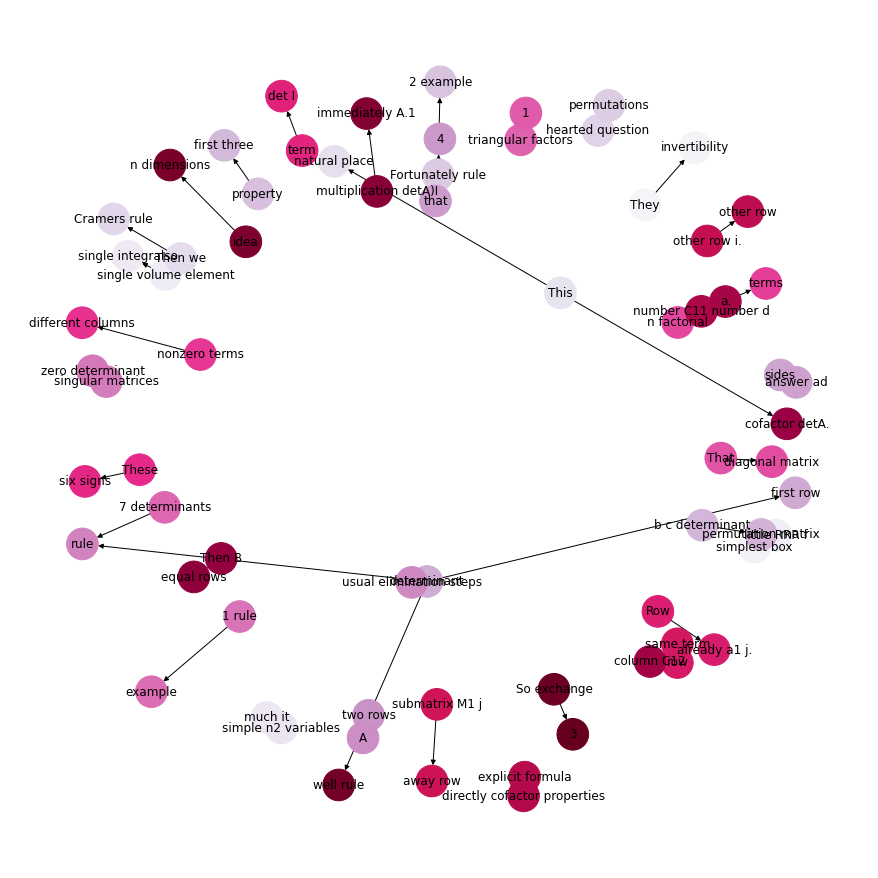

In [13]:
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_size=1000, node_color=range(G.number_of_nodes()), 
        pos=pos, cmap=plt.cm.PuRd)
plt.show()


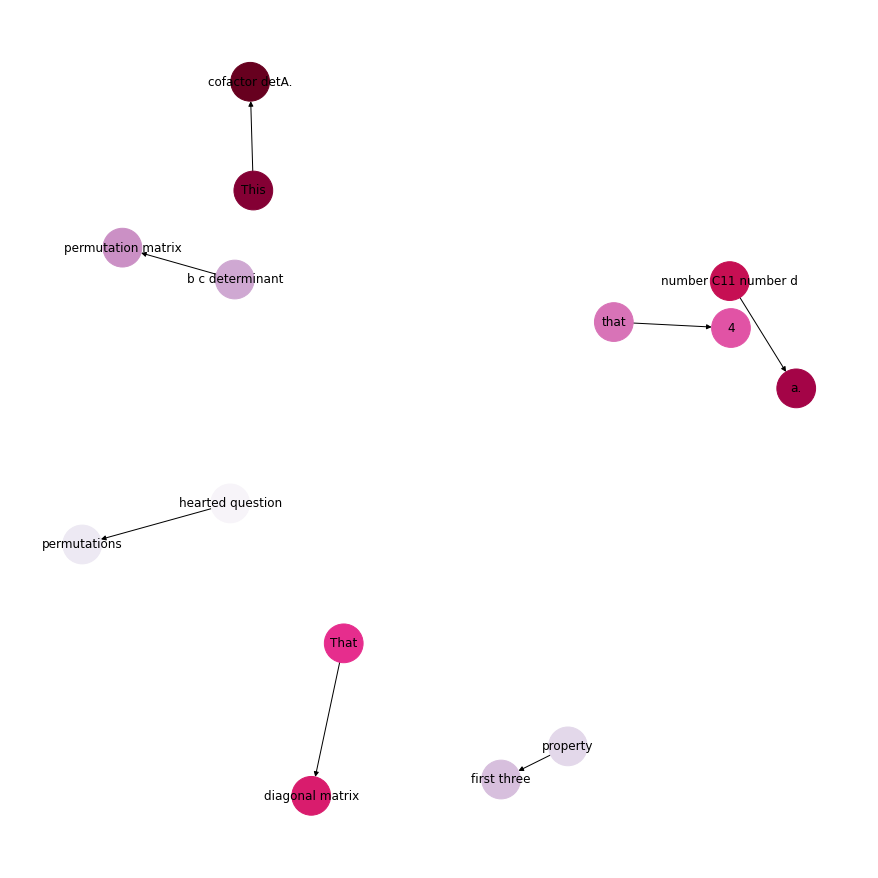

In [14]:
G_smol = nx.from_pandas_edgelist(kg_df[kg_df['link']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G_smol, k=.4)
nx.draw(G_smol, with_labels=True, node_color=range(G_smol.number_of_nodes()), 
        node_size=1500, cmap=plt.cm.PuRd, pos=pos)
plt.show()


In [15]:
# Adding weights to graph edges for better question selection
popukarity = dict(G.out_degree())
popukarity

{'They': 1,
 'invertibility': 0,
 'simplest box': 1,
 'little RRR f': 0,
 'single volume element': 1,
 'single integralso': 0,
 'much it': 1,
 'simple n2 variables': 0,
 'This': 2,
 'natural place': 0,
 'Then we': 1,
 'Cramers rule': 0,
 'hearted question': 1,
 'permutations': 0,
 'Fortunately rule': 1,
 '2 example': 0,
 'property': 1,
 'first three': 0,
 'b c determinant': 1,
 'permutation matrix': 0,
 'determinant': 3,
 'first row': 0,
 'sides': 1,
 'answer ad': 0,
 'that': 1,
 '4': 0,
 'two rows': 1,
 'A': 0,
 'usual elimination steps': 1,
 'rule': 0,
 'singular matrices': 1,
 'zero determinant': 0,
 '1 rule': 1,
 'example': 0,
 '7 determinants': 1,
 'triangular factors': 1,
 '1': 0,
 'That': 1,
 'diagonal matrix': 0,
 'n factorial': 1,
 'terms': 0,
 'nonzero terms': 1,
 'different columns': 0,
 'These': 1,
 'six signs': 0,
 'term': 1,
 'det I': 0,
 'Row': 1,
 'already a1 j.': 0,
 'row': 1,
 'same term': 0,
 'submatrix M1 j': 1,
 'away row': 0,
 'other row i.': 1,
 'other row': 0,
 

In [16]:
for u,v,d in G.edges(data=True):
    d['weight'] = popukarity[u] + popukarity[v]  # weight is the the sum of outdegrees of the vertices connected by the edge


In [17]:
indexes = np.flip(np.argsort(np.array([x[2]['weight'] for x in G.edges(data=True)])))


In [18]:
def create_gap_filled_question(body, subject):
    question = body.replace(subject, '_' * len(subject))
    print(question)
    print('Answer:', subject)
    

In [19]:
sentences = np.array(sentences)
top_sentences = sentences[indexes]
top_sentences[:10]

array(['For example, d(I) = detB=detB = 1; rule 1 is satisfied.',
       'If two rows of A are equal, then detA = 0.',
       'If only one side is stretched, the volume and determinant go up by 4; that is rule 3.',
       'Both sides give the answer ad + a0d.bc.b0c.',
       'Then B has two equal rows, and detB = 0.',
       'This suggests the natural place to begin.',
       'Then we compute x=A.1b by Cramers rule.',
       'So would an exchange of 3 and 2, then 3 and 1, and then 2 and 1.',
       'The determinant depends linearly on the first row.',
       'The determinant is unchanged, by rule 5.'], dtype='<U139')

In [34]:
create_gap_filled_question(top_sentences[8], subjects[indexes[8]])

 The ___________ is unchanged, by rule 5.
Answer: determinant


In [20]:
unique, counts = np.unique(subjects, return_counts=True)
np.asarray((unique, counts)).T

array([['1 rule', '1'],
       ['7 determinants', '1'],
       ['Fortunately rule', '1'],
       ['Row', '1'],
       ['So exchange', '1'],
       ['That', '1'],
       ['Then B', '1'],
       ['Then we', '1'],
       ['These', '1'],
       ['They', '1'],
       ['This', '2'],
       ['b c determinant', '1'],
       ['column C12', '1'],
       ['determinant', '3'],
       ['explicit formula', '1'],
       ['hearted question', '1'],
       ['idea', '1'],
       ['much it', '1'],
       ['multiplication detA)I', '1'],
       ['n factorial', '1'],
       ['nonzero terms', '1'],
       ['number C11 number d', '1'],
       ['other row i.', '1'],
       ['property', '1'],
       ['row', '1'],
       ['sides', '1'],
       ['simplest box', '1'],
       ['single volume element', '1'],
       ['singular matrices', '1'],
       ['submatrix M1 j', '1'],
       ['term', '1'],
       ['that', '1'],
       ['triangular factors', '1'],
       ['two rows', '1'],
       ['usual elimination steps', '1']

In [ ]:
# TODO: The entities mentioned in the question’s clues should not contain tokens that
#overlap with the answer entity (e.g., A fact asking about Leonardo da Vinci’s
#birthplace Vinci, Florence should be filtered out).
